In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


class LAM_Linear(nn.Module):
    def __init__(self, d_o, d_z):
        super(LAM_Linear, self).__init__()
        # self.A = nn.Linear(d_o, d_o, bias=False)
        # self.B = nn.Linear(d_z, d_o, bias=False)
        self.C = nn.Linear(d_o, d_z, bias=False)
        self.D = nn.Linear(d_o, d_z, bias=False)
        self.E = nn.Linear(d_z, d_o, bias=False)


    def forward(self, o, o_next):
        z = self.C(o) + self.D(o_next)
        obs_pred = o + self.E(z)
        return obs_pred

In [18]:
def generate_true_U(action_embeddings):
    N = 10000

    actions = np.random.randint(num_actions, size=(N,))
    A = np.zeros((num_actions, N))
    A[actions, np.arange(N)] = 1

    Q = action_embeddings @ A 

    U, S, V = np.linalg.svd(Q)
    return U

def principal_angles(X, Y):
    # Orthonormalize the basis vectors using QR decomposition
    Q1, _ = np.linalg.qr(X)
    Q2, _ = np.linalg.qr(Y)
    
    # Compute the product of transposed Q1 and Q2
    M = Q1.T @ Q2
    
    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(M)

    # Clip singular values to avoid numerical errors (arccos domain [-1, 1])
    S_clipped = np.clip(S, -1.0, 1.0)

    # Compute principal angles in radians (sorted in ascending order)
    angles_rad = np.arccos(S_clipped)
    
    return angles_rad

def tensorboard_smooth(data, alpha=0.6):
    """Apply exponential moving average smoothing to 1D data.
    
    Args:
        data: Input array (np.ndarray or pd.Series)
        alpha: Smoothing factor (0 < alpha ≤ 1), default 0.6 (TensorBoard's default)
    
    Returns:
        Smoothed array with same dtype as input
    """
    # Convert Series to numpy array while preserving index
    if isinstance(data, pd.Series):
        original_index = data.index
        data = data.values
    else:
        original_index = None

    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    
    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]

    # Reconstruct original data type
    return pd.Series(smoothed, index=original_index) if original_index is not None else smoothed

In [19]:
N = 128
num_actions = 3
num_others = 2
dim = 5
dim_z = 3
discrete_actions = True

action_embeddings = np.random.randn(dim, num_actions)
action_embeddings[3:] = 0
action_embeddings, _ = np.linalg.qr(action_embeddings) 
action_embeddings = action_embeddings * 1.6
# action_embeddings = action_embeddings / np.linalg.norm(action_embeddings, axis=0, keepdims=True)

others_embeddings = np.random.randn(dim, num_others)
others_embeddings[:3] = 0
others_embeddings, _ = np.linalg.qr(others_embeddings) 
others_embeddings = others_embeddings * 1.6

true_U = generate_true_U(action_embeddings)
main_lam = LAM_Linear(dim, dim_z)

record = []

for epsilon in [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]:

    lam = LAM_Linear(dim, dim_z)
    lam.load_state_dict(main_lam.state_dict())
    opt = optim.Adam(lam.parameters())

    for i_batch in range(5000):

        if discrete_actions:
            actions = np.random.randint(num_actions, size=(N,))
            A = np.zeros((num_actions, N))
            A[actions, np.arange(N)] = 1
        else:
            A = np.random.rand(num_actions, N)

        if discrete_actions:
            bctions = np.random.randint(num_others, size=(N,))
            B = np.zeros((num_others, N))
            B[bctions, np.arange(N)] = 1
            noise = others_embeddings @ B
            noise = noise * epsilon

        Q = action_embeddings @ A 

        O = np.random.rand(dim, N)
        Op = O + Q + noise

        tensor_O = torch.tensor(O.T, dtype=torch.float32)
        tensor_Op = torch.tensor(Op.T, dtype=torch.float32)

        loss = nn.MSELoss()(lam(tensor_O, tensor_Op), tensor_Op)
        opt.zero_grad()
        loss.backward()
        opt.step()

        angles = principal_angles(action_embeddings, lam.E.weight.detach().numpy())
        max_angle = np.max(angles)
        bngles = principal_angles(others_embeddings, lam.E.weight.detach().numpy())
        max_bngle = np.max(bngles)

        record.append({
            'noise': epsilon,
            'batch': i_batch,
            'loss': loss.item(),
            'angle': max_angle,
            'bngle': max_bngle,
        })

record = pd.DataFrame(record)


Text(0.5, 1.0, 'Principal Angle between Decoder and \n Ground Truth $Y$ (RAD)')

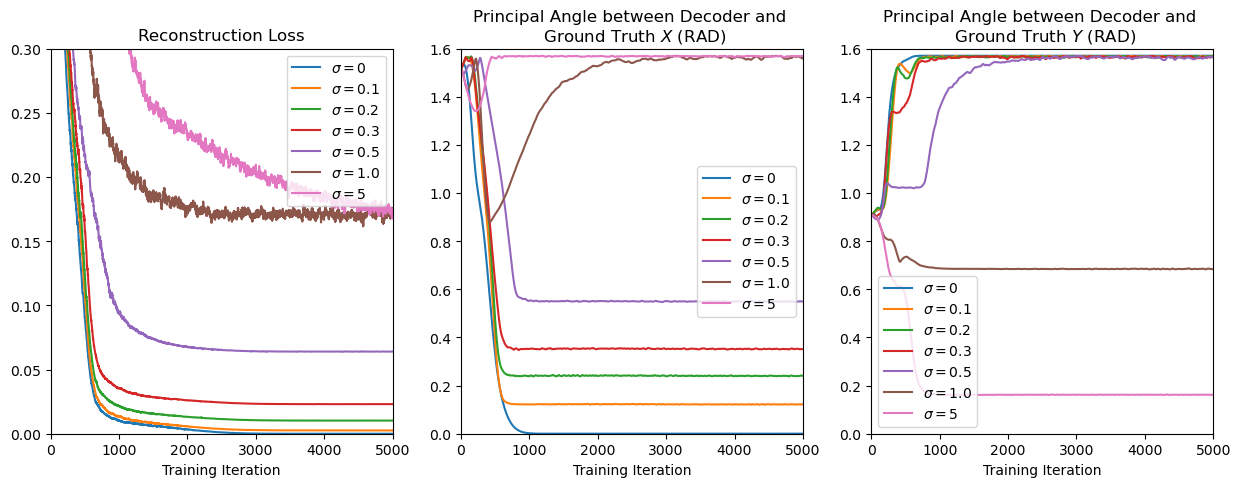

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for epsilon in [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.3])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Reconstruction Loss')

plt.subplot(1, 3, 2)
for epsilon in [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['angle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $X$ (RAD)')

plt.subplot(1, 3, 3)
for epsilon in [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['bngle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $Y$ (RAD)')